### Jonathan Bunch

24 October 2021

Bellevue University

DSC550-T301

---

# Final Project Milestone Three

Before I begin the modeling stage of this milestone, I will attempt to better organize my data to identify/create some
new features to work with.  The feedback from last week's milestone helped me identify some new ideas for extracting
information and grouping my features in a relevant way.  My sample size is still quite small, but I believe these
changes have significantly improved the amount of information available for modeling.  I also chose to re-integrate
a secondary data set that includes yearly statistics on fertility rate, mortality rate, and per capita income.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [4]:
# Import my data sets.
disney_raw = pd.read_csv("disney_movies_total_gross.csv")
fmi_raw = pd.read_csv("MortalityFertilityIncome.csv", decimal=',')

First, I will filter and re-organize the mortality/fertility/income data set.

In [5]:
# Isolate the data for the country of interest.
fmi_1 = fmi_raw[fmi_raw['Country Name'] == "United States"]
# Drop unnecessary columns.
fmi_1 = fmi_1.drop(columns=['Country Name', 'Country Code', 'Region']).reset_index(drop=True)
print('Shape: ', fmi_1.shape, '\n')
fmi_1.head()

Shape:  (1, 141) 



,m1970,m1971,m1972,m1973,m1974,m1975,m1976,m1977,m1978,m1979,...,i2007,i2008,i2009,i2010,i2011,i2012,i2013,i2014,i2015,i2016
0,19.9,19.1,18.3,17.5,16.7,16.0,15.2,14.5,13.8,13.2,...,40594.21177,40369.26202,39379.54994,40903.86626,42607.52741,44582.33345,45548.28824,47344.28554,49058.0894,49725.78053


As we can see, the data structure is not very useful. I need to split the one long row into columns based on the
prefix in the column name, and create rows based on the year.

In [6]:
# I will use the Pandas "wide_to_long" method to "unpivot" these data.
fmi_1['id'] = fmi_1.index
fmi_2 = pd.wide_to_long(fmi_1, stubnames=['m', 'f', 'i'], i='id', j='year')
fmi_2 = fmi_2.reset_index(level='id', drop=True)
# Rename the columns.
fmi_3 = fmi_2.rename(columns={'m': 'mortality', 'f': 'fertility', 'i': 'income_per_cap'})
fmi_3.head()

,mortality,fertility,income_per_cap
year,,,
1970,19.9,2.480,4591.218634
1971,19.1,2.266,4891.985558
1972,18.3,2.010,5305.320034
1973,17.5,1.879,5912.942042
1974,16.7,1.835,6152.478813


Now I will start on the Disney movie dataset. Based on feedback from the last milestone, I want to organize this data
set a little differently and try creating some new features.

In [7]:
# Drop irrelevant features.  I found previously that 'mpaa_rating' had too many missing values to be useful.
ddf_1 = disney_raw.drop(columns=['movie_title', 'total_gross', 'mpaa_rating'])
print('NA Values: ')
print(ddf_1.isna().sum())
# As before, I will consider any observation that has a zero value for the adjusted profits to be a missing value.
print('Dataframe shape: ', ddf_1.shape)
print('Missing Values for Profit: ', (ddf_1.inflation_adjusted_gross == 0).sum())
# There are only four missing values, so I'm going to simply drop those observations.
ddf_1 = ddf_1[ddf_1.inflation_adjusted_gross != 0]
print('New Dataframe shape: ', ddf_1.shape)

NA Values: 
release_date                0
genre                       0
inflation_adjusted_gross    0
dtype: int64
Dataframe shape:  (579, 3)
Missing Values for Profit:  4
New Dataframe shape:  (575, 3)


In [8]:
# Now I will convert the date column to a datetime datatype to make it easier to work with.
ddf_1.release_date = ddf_1.release_date.astype(np.datetime64)
# I am going to create features from the month and year, and drop the orginal date column.
ddf_1.loc[:, 'year'] = ddf_1.release_date.apply(lambda x: x.year)
ddf_1.loc[:, 'month'] = ddf_1.release_date.apply(lambda x: x.month)
ddf_2 = ddf_1.drop(columns='release_date')
ddf_2.head()

,genre,inflation_adjusted_gross,year,month
0,Musical,5228953251,1937,12
1,Adventure,2188229052,1940,2
2,Musical,2187090808,1940,11
3,Adventure,1078510579,1946,11
4,Drama,920608730,1950,2


The second dataset contains data from 1970 to 2016.  The Disney dataset contains data from 1937 to 2016, but almost
all of the observations are from 1970 or later.  I would argue that dropping the 15 observations from before 1970
is justified because they represent only a small proportion of the total observations, and because they would
represent several decades with only a handful of observations.

In [9]:
# Drop observations from before 1970.
ddf_2 = ddf_2[ddf_2.year >= 1970]
ddf_2 = ddf_2.reset_index(drop=True)

Next I want to create some quick exploratory visualizations.

In [10]:
# Create variables for yearly movie releases, profits, and profits per movie.
x_year = ddf_2.year.value_counts().sort_index().index
count_year = ddf_2.year.value_counts().sort_index()
yearly_sum_profits = ddf_2.groupby(['year']).sum().inflation_adjusted_gross
yearly_per_movie = yearly_sum_profits / count_year

# Create the same metrics for monthly values.
x_month = ddf_2.month.value_counts().sort_index().index
count_month = ddf_2.month.value_counts().sort_index()
monthly_sum_profits = ddf_2.groupby(['month']).sum().inflation_adjusted_gross
monthly_per_movie = monthly_sum_profits / count_month

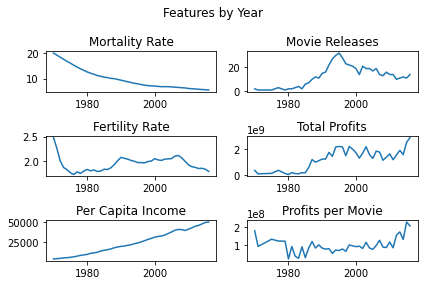

In [11]:
# Create simple plots of feature values by year.
fig, axs = plt.subplots(3, 2)
fig.suptitle('Features by Year')
axs[0, 0].plot(fmi_3.index, fmi_3.mortality)
axs[0, 0].set_title("Mortality Rate")
axs[1, 0].plot(fmi_3.index, fmi_3.fertility)
axs[1, 0].set_title("Fertility Rate")
axs[2, 0].plot(fmi_3.index, fmi_3.income_per_cap)
axs[2, 0].set_title("Per Capita Income")
axs[0, 1].plot(x_year, count_year)
axs[0, 1].set_title("Movie Releases")
axs[1, 1].plot(yearly_sum_profits.index, yearly_sum_profits.values)
axs[1, 1].set_title("Total Profits")
axs[2, 1].plot(x_year, yearly_per_movie)
axs[2, 1].set_title("Profits per Movie")
fig.tight_layout()
plt.show()

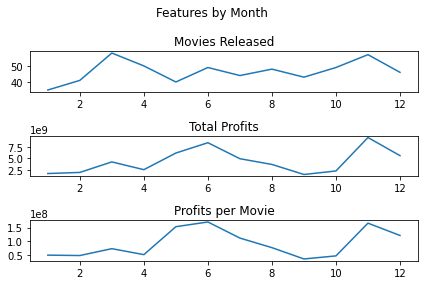

In [12]:
# Create similar plots for monthly feature values.  This level of detail is only available in the Disney dataset.
fig, axs = plt.subplots(3, 1)
fig.suptitle('Features by Month')
axs[0].plot(x_month, count_month)
axs[0].set_title("Movies Released")
axs[1].plot(x_month, monthly_sum_profits.values)
axs[1].set_title("Total Profits")
axs[2].plot(x_month, (monthly_sum_profits.values / count_month.values))
axs[2].set_title("Profits per Movie")
fig.tight_layout()
plt.show()

From the initial visual inspection, it looks like there could be some co-variance in several of these features. The
mortality rate and per capita income may not contain much information since they seem to have pretty consisten rates
of change, but I will keep them for now.  Fertility rate dropped dramatically around the early 1970s, perhaps due to
increased available or acceptance of birth control.  Using data from after ~1980 could improve the predictive power,
but it might be difficult to justify without more information.

The monthly data also shows some interesting patterns.  It appears that, overall, profits are higher for movies
released mid-year and around the end of the year.  This is logical since summer and holiday releases have historically
been promoted by the film industry, and families often have more time to spend together during these periods.

Next, I will create dummy variables for the month of release.  I will also create dummy variables for the genre
variable, which I have not explored much yet.  Then, I can calculate the yearly sum of each feature and re-organize
the dataframe to represent yearly observations.

In [13]:
# Create dummy variables.
month_dummies = pd.get_dummies(ddf_2.month, prefix='month')
genre_dummies = pd.get_dummies(ddf_2.genre, prefix='genre')
# Join the dummy variables to the original dataframe.
ddf_3 = ddf_2.join([month_dummies, genre_dummies])
# Drop the original columns.
ddf_3 = ddf_3.drop(columns=['month', 'genre'])
# Group the data by year using sum to aggregate.
ddf_4 = ddf_3.groupby(['year']).sum()
ddf_4.head()

,inflation_adjusted_gross,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,genre_Black Comedy,genre_Comedy,genre_Concert/Performance,genre_Documentary,genre_Drama,genre_Horror,genre_Musical,genre_Romantic Comedy,genre_Thriller/Suspense,genre_Western
year,,,,,,,,,,,,,,,,,,,,,
1970,356362241,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1971,91305448,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1975,131246872,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1977,363659174,1,0,0,0,0,2,0,0,0,...,0,2,0,0,0,0,0,0,0,0
1979,120377374,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I will visualize a few of the features just out of curiosity.

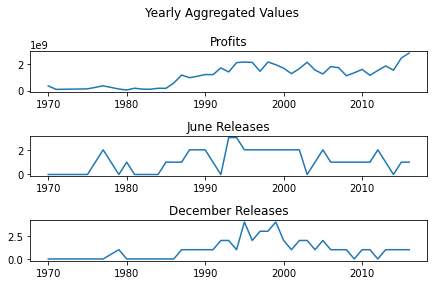

In [14]:
fig, axs = plt.subplots(3, 1)
fig.suptitle('Yearly Aggregated Values')
axs[0].plot(ddf_4.index, ddf_4.inflation_adjusted_gross.values)
axs[0].set_title("Profits")
axs[1].plot(ddf_4.index, ddf_4.month_6.values)
axs[1].set_title("June Releases")
axs[2].plot(ddf_4.index, ddf_4.month_12.values)
axs[2].set_title("December Releases")
fig.tight_layout()
plt.show()

Everything looks pretty good, so I will combine the two datasets.  I'm using the default left join method since the
Disney dataset does not have an observation for every year.

In [15]:
combined_df = ddf_4.join(fmi_3)
combined_df.head()

,inflation_adjusted_gross,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,genre_Documentary,genre_Drama,genre_Horror,genre_Musical,genre_Romantic Comedy,genre_Thriller/Suspense,genre_Western,mortality,fertility,income_per_cap
year,,,,,,,,,,,,,,,,,,,,,
1970,356362241,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,19.9,2.480,4591.218634
1971,91305448,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,19.1,2.266,4891.985558
1975,131246872,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,16.0,1.774,6564.002627
1977,363659174,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,14.5,1.790,7990.411096
1979,120377374,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,13.2,1.808,9557.345962


Next, I'm going to create a correlation matrix to get an idea of which features might be the most relevant.

In [16]:
# Create a correlation matrix.
corr_1 = combined_df.corr()
print(corr_1)
# We can create a sorted list of correlation values to see the highest absolute values.
corr_sorted = corr_1.inflation_adjusted_gross.sort_values()
print(corr_sorted)

                           inflation_adjusted_gross   month_1   month_2  \
inflation_adjusted_gross                   1.000000  0.444893  0.497789   
month_1                                    0.444893  1.000000  0.144895   
month_2                                    0.497789  0.144895  1.000000   
month_3                                    0.631767  0.522743  0.522132   
month_4                                    0.532090  0.494807  0.390556   
month_5                                    0.757830  0.193254  0.602483   
month_6                                    0.458048  0.486331  0.471214   
month_7                                    0.398606  0.266867  0.406192   
month_8                                    0.580098  0.434554  0.450605   
month_9                                    0.554870  0.605263  0.475018   
month_10                                   0.484291  0.472236  0.441289   
month_11                                   0.618448  0.078249  0.471188   
month_12                 

Finally, I am ready to create my first model.  I will start with a simple linear regression model for this milestone.
I will explore feature selection and alternate models more thoroughly moving forward, but for now I will simply select
the four features that have a correlation above 0.7: month_5, genre_Adventure, mortality, and income_per_cap.

In [17]:
# For convenience, I will assign the target feature (profits) and predictive features to variables.
target = combined_df.inflation_adjusted_gross
predictives = combined_df.loc[:, ['month_5', 'genre_Adventure', 'mortality', 'income_per_cap']]

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(predictives, target, test_size=0.2, random_state=4)

# Create and fit a linear regression model.
model = LinearRegression()
model.fit(X_train, y_train)
# Use the model to make some predictions.
y_pred = model.predict(X_test)

# I will also create a "dummy" model for comparison.
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dum_pred = dummy.predict(X_test)

Now I will evaluate the model.  I will calculate several metrics for both the actual model and the dummy model and
compare the results.

In [18]:
# Calculate evaluation metrics for the regression model.
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
# Calculate the same metrics for the dummy model.
dum_r2 = r2_score(y_test, dum_pred)
dum_mae = mean_absolute_error(y_test, dum_pred)
dum_mse = mean_squared_error(y_test, dum_pred)
dum_evs = explained_variance_score(y_test, dum_pred)
# And the difference between the two.
diff_r2 = r2 - dum_r2
diff_mae = mae - dum_mae
diff_mse = mse - dum_mse
diff_evs = evs - dum_evs

In [19]:
# Print the results.
print('Baseline "Dummy" Model Results:')
print("R-squared score:            ", dum_r2)
print("Explained Variance Score:   ", dum_evs)
print("Mean Absolute Error:        ", dum_mae)
print("Mean Squared Error:         ", dum_mse)
# Actual Model
print()
print('Actual Regression Model Results:')
print("R-squared score:            ", r2)
print("Explained Variance Score:   ", evs)
print("Mean Absolute Error:        ", mae)
print("Mean Squared Error:         ", mse)
# Difference.
print()
print('Difference Between Regression Model and Baseline Model:')
print("R-squared score:            ", diff_r2)
print("Explained Variance Score:   ", diff_evs)
print("Mean Absolute Error:        ", diff_mae)
print("Mean Squared Error:         ", diff_mse)

Baseline "Dummy" Model Results:
R-squared score:             -0.09514217205833497
Explained Variance Score:    0.0
Mean Absolute Error:         746183037.2424244
Mean Squared Error:          8.317064509655095e+17

Actual Regression Model Results:
R-squared score:             0.721302921461923
Explained Variance Score:    0.7305242779974269
Mean Absolute Error:         377605384.7148455
Mean Squared Error:          2.1165668166143174e+17

Difference Between Regression Model and Baseline Model:
R-squared score:             0.816445093520258
Explained Variance Score:    0.7305242779974269
Mean Absolute Error:         -368577652.5275789
Mean Squared Error:          -6.200497693040778e+17


We can see from the results that this regression model performed significantly better than a baseline model.  The
R-squared and Explained Variance scores were much higher, and the error values were much lower.  Moving forward,
I will continue to explore different models and reduce my features to only those that contribute significant value
to the models.